<a href="https://colab.research.google.com/github/karthik19-cloud/GenAI-Training/blob/main/house_price_prediction_3d-plot-output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os, io, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (enables 3D)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# -------- 0) Point to your file OR upload ----------
# Option A: if you already placed it in sample_data
DATA_PATH = "/content/sample_data/housing.csv"

if not os.path.exists(DATA_PATH):
    # Option B: upload interactively
    from google.colab import files
    uploaded = files.upload()
    DATA_PATH = list(uploaded.keys())[0]

print("Using file:", DATA_PATH)


Using file: /content/sample_data/housing.csv


In [9]:
# -------- 1) Robust loader (CSV or whitespace, header or none) ----------
def try_read(path):
    # First try standard CSV (handles header)
    try:
        df = pd.read_csv(path)
        if df.select_dtypes(include=[np.number]).shape[1] >= 2:
            return df
    except Exception:
        pass
    # Try whitespace-separated with header guessed
    try:
        df = pd.read_csv(path, sep=r"\s+", engine="python")
        if df.select_dtypes(include=[np.number]).shape[1] >= 2:
            return df
    except Exception:
        pass
    # Final: assume Boston Housing w/out header and assign names
    col_names = [
        "CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX",
        "PTRATIO","B","LSTAT","MEDV"
    ]
    df = pd.read_csv(path, sep=r"\s+|,", engine="python", header=None, names=col_names)
    return df

df = try_read(DATA_PATH)
df = df.dropna(how="all").copy()
df.columns = [c.strip() for c in df.columns]


In [10]:
# -------- 2) Detect target (MEDV typical); fallback last column ----------
target_candidates = ["MEDV","Price","SalePrice","price","saleprice","target","Target","label","y"]
target_col = next((c for c in df.columns if c in target_candidates), df.columns[-1])

# Keep numeric only
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col not in num_cols:
    raise ValueError(f"Detected target '{target_col}' is not numeric. Numeric columns: {num_cols}")

In [11]:
#-------- 3) Choose top-2 features by |corr| with target ----------
corr = df[num_cols].corr(numeric_only=True)[target_col].drop(labels=[target_col], errors="ignore")
top2 = corr.abs().sort_values(ascending=False).index[:2].tolist()
feat1, feat2 = top2[0], top2[1]
print(f"Target: {target_col} | Top-2 features: {feat1}, {feat2}")

# -------- 4) Model: Linear Regression on ALL numeric features ----------
X = df[num_cols].drop(columns=[target_col])
y = df[target_col].values

pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])
pipeline.fit(X, y)


Target: 24.00 | Top-2 features: 4.98, 6.5750


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('reg', LinearRegression())])

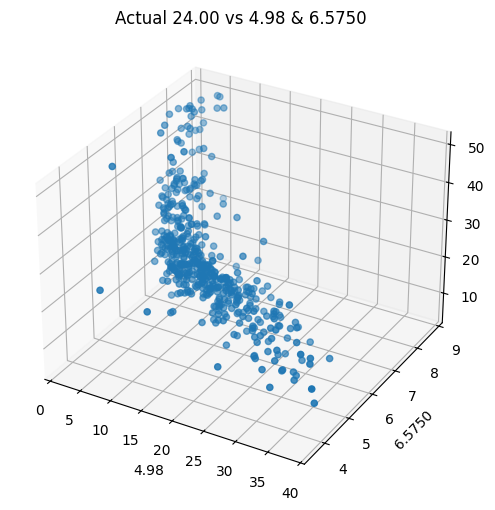

In [12]:
# -------- 5) 3D scatter of actual data ----------
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection="3d")
ax1.scatter(df[feat1], df[feat2], df[target_col])
ax1.set_xlabel(feat1)
ax1.set_ylabel(feat2)
ax1.set_zlabel(target_col)
ax1.set_title(f"Actual {target_col} vs {feat1} & {feat2}")
plt.show()

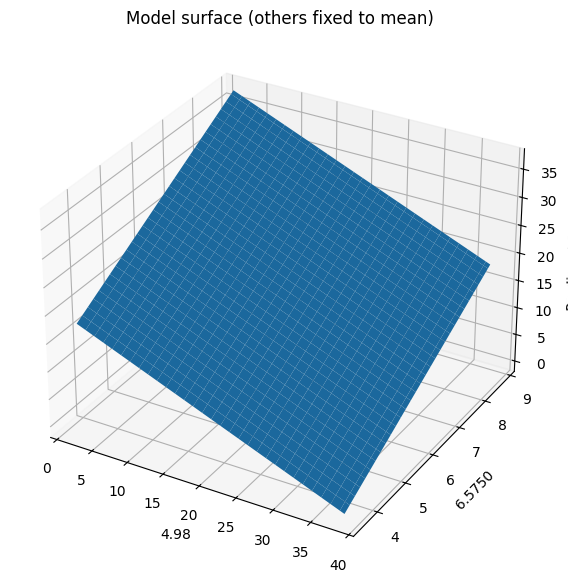

In [13]:
# -------- 6) 3D surface of predictions (others fixed to mean) ----------
means = X.mean(numeric_only=True)
f1_lin = np.linspace(df[feat1].min(), df[feat1].max(), 60)
f2_lin = np.linspace(df[feat2].min(), df[feat2].max(), 60)
F1, F2 = np.meshgrid(f1_lin, f2_lin)

grid_rows = F1.size
grid_df = pd.DataFrame({col: np.full(grid_rows, means[col]) for col in X.columns})
grid_df[feat1] = F1.ravel()
grid_df[feat2] = F2.ravel()

Z = pipeline.predict(grid_df).reshape(F1.shape)

fig2 = plt.figure(figsize=(9, 7))
ax2 = fig2.add_subplot(111, projection="3d")
ax2.plot_surface(F1, F2, Z)
ax2.set_xlabel(feat1)
ax2.set_ylabel(feat2)
ax2.set_zlabel(f"Predicted {target_col}")
ax2.set_title("Model surface (others fixed to mean)")
plt.show()


In [14]:
# -------- 7) (Optional) Save figures ----------
fig1_path = "/content/house_3d_scatter.png"
fig2_path = "/content/house_3d_surface.png"
fig1.savefig(fig1_path, dpi=150, bbox_inches="tight")
fig2.savefig(fig2_path, dpi=150, bbox_inches="tight")
print("Saved:", fig1_path, fig2_path)

# NOTE: If you want to visualize an ANN you trained elsewhere,
# replace the LinearRegression pipeline with your Keras model:
#   keras_model = tf.keras.models.load_model('path_to_model')
#   def predict_fn(df_batch): return keras_model.predict(df_batch_preprocessed).ravel()
# and set Z = predict_fn(grid_df).reshape(F1.shape)

Saved: /content/house_3d_scatter.png /content/house_3d_surface.png
